In [24]:
"""
graph_SCModal_testing.py

Test out the updated SCModal framework to account for spatial modality
on the full Xeminum dataset.

Outputs:
 - 
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import umap
import scanpy as sc
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import random

In [25]:
# ---------------------------
# Data loading & preprocessing
# ---------------------------
def load_and_preprocess(ref_path="SmallData/xenium_reference_common_genes.h5ad",
                        spat_path="SmallData/xenium_spatial_common_genes.h5ad"):
    # load
    B = sc.read_h5ad(ref_path)
    A = sc.read_h5ad(spat_path)

    # Prefer obs column with broad labels (user should have created 'broad_cell_type' earlier)
    possible_ref_cols = ["broad_cell_type", "celltype_major", "celltype", "cell_type"]
    ref_label_col = next((c for c in possible_ref_cols if c in B.obs.columns), None)
    possible_spat_cols = ["broad_cell_type", "cell_type", "predicted_label"]
    spat_label_col = next((c for c in possible_spat_cols if c in A.obs.columns), None)

    if ref_label_col is None:
        raise RuntimeError("Reference label column not found. Set 'broad_cell_type' or similar in B.obs.")
    if spat_label_col is None:
        print("Warning: spatial label column not found. Spatial labels will be None (can't compute test acc).")

    # Normalize total and log1p (inplace on copies)
    Bc = B.copy()
    Ac = A.copy()
    sc.pp.normalize_total(Bc, target_sum=1e4)
    sc.pp.log1p(Bc)
    sc.pp.normalize_total(Ac, target_sum=1e4)
    sc.pp.log1p(Ac)

    # Convert to dense arrays (small 2k dataset assumed)
    X_ref = Bc.X.toarray() if hasattr(Bc.X, "toarray") else Bc.X
    X_spat = Ac.X.toarray() if hasattr(Ac.X, "toarray") else Ac.X

    # labels
    y_ref = Bc.obs[ref_label_col].astype(str).values
    y_spat = Ac.obs[spat_label_col].astype(str).values if spat_label_col in Ac.obs.columns else None

    # map labels to ints
    all_labels = np.unique(np.concatenate([y_ref] + ([y_spat] if y_spat is not None else [])))
    label_to_id = {lab: i for i, lab in enumerate(all_labels)}
    y_ref_id = np.array([label_to_id[l] for l in y_ref])
    y_spat_id = np.array([label_to_id[l] for l in y_spat]) if y_spat is not None else None

    # spatial coords
    if "spatial" not in Ac.obsm_keys():
        raise RuntimeError("Spatial coords key 'spatial' not found in A.obsm.")
    coords = Ac.obsm["spatial"]

    return (X_ref.astype(np.float32), y_ref_id, Bc.obs_names.values, label_to_id,
            X_spat.astype(np.float32), y_spat_id, Ac.obs_names.values, coords, all_labels)


In [3]:
X_ref, y_ref, ref_ids, label_to_id, X_spat, y_spat, spat_ids, coords, all_labels = load_and_preprocess(
         ref_path="/data/keerthana/integration/scMODAL/xenium_sc_data.h5ad",
         spat_path="/data/keerthana/integration/scMODAL/xenium_breast_cancer.h5ad"
)

print('Loaded datasets:')
print('X_ref shape:', getattr(X_ref, 'shape', None))
print('X_spat shape:', getattr(X_spat, 'shape', None))
print('coords shape:', getattr(coords, 'shape', None))

/home/keerthana/anaconda3/envs/scmodal_scviva/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/keerthana/anaconda3/envs/scmodal_scviva/lib/python3.10/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)


Loaded datasets:
X_ref shape: (100064, 29733)
X_spat shape: (167780, 313)
coords shape: (167780, 2)


In [4]:
from scmodal.model import Model

In [5]:
m = Model(batch_size=64, training_steps=20000, n_latent=16, n_KNN=10,
          lambdaAE=10.0, lambdaLA=8.0, lambdaMNN=2.0, lambdaGeo=8.0, lambdaGAN=1)
print('Model created. Running preprocess...')

Model created. Running preprocess...


In [6]:
adata_ref = sc.read_h5ad('/data/keerthana/integration/scMODAL/xenium_sc_data.h5ad')
adata_spat = sc.read_h5ad('/data/keerthana/integration/scMODAL/xenium_breast_cancer.h5ad')
print('AnnData shapes:', adata_ref.shape, adata_spat.shape)

AnnData shapes: (100064, 29733) (167780, 313)


/home/keerthana/anaconda3/envs/scmodal_scviva/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [7]:
m.preprocess(adata_spat, adata_ref, shared_gene_num=308)
print('Preprocess completed in Model.')
print('emb_A shape:', getattr(m, 'emb_A', None).shape)
print('coords_A shape:', getattr(m, 'coords_A', None).shape)
print('emb_B shape:', getattr(m, 'emb_B', None).shape)
print('coords_B shape:', getattr(m, 'coords_B', None))

Preprocessing complete.
A: (167780, 313), coords: (167780, 2)
B: (100064, 29733), coords: None
Preprocess completed in Model.
emb_A shape: (167780, 313)
coords_A shape: (167780, 2)
emb_B shape: (100064, 29733)
coords_B shape: None


In [8]:
m.train()

Begining time:  Thu Nov 27 03:52:45 2025
step 0, loss_D=50.000000, loss_GAN=-50.000000, loss_AE=7212410.000000, loss_Geo=-6.099748, loss_LA=5189986816.000000, loss_MNN=4361376.000000
step 2000, loss_D=0.001679, loss_GAN=-0.001573, loss_AE=57.070229, loss_Geo=-12.310217, loss_LA=1295.416870, loss_MNN=360.270203
step 4000, loss_D=0.003076, loss_GAN=-0.003017, loss_AE=53.191483, loss_Geo=-12.240311, loss_LA=191.761505, loss_MNN=53.315071
step 6000, loss_D=0.911613, loss_GAN=-0.894614, loss_AE=72.071487, loss_Geo=-12.289112, loss_LA=5.698068, loss_MNN=1.862453
step 8000, loss_D=1.037904, loss_GAN=-0.913254, loss_AE=57.346588, loss_Geo=-12.251523, loss_LA=0.174467, loss_MNN=0.033942
step 10000, loss_D=0.959669, loss_GAN=-0.930601, loss_AE=18.204201, loss_Geo=-13.019046, loss_LA=0.352680, loss_MNN=1.332439
step 12000, loss_D=1.038886, loss_GAN=-0.964323, loss_AE=11.509748, loss_Geo=-13.512321, loss_LA=0.505401, loss_MNN=0.718395
step 14000, loss_D=1.079603, loss_GAN=-1.064766, loss_AE=12.748

step 0, loss_D=0.005665, loss_GAN=-0.005445, loss_AE=4632716.000000, loss_Geo=-11.496536, loss_LA=53687760.000000, loss_MNN=2965938.750000
step 2000, loss_D=0.000935, loss_GAN=-0.000839, loss_AE=50.457344, loss_Geo=-11.900495, loss_LA=412.380737, loss_MNN=406.855011
step 4000, loss_D=0.002303, loss_GAN=-0.002222, loss_AE=57.974186, loss_Geo=-12.176163, loss_LA=126.373291, loss_MNN=33.262291
step 6000, loss_D=0.006094, loss_GAN=-0.006054, loss_AE=62.235146, loss_Geo=-12.530744, loss_LA=17.281181, loss_MNN=4.646034
step 8000, loss_D=1.079033, loss_GAN=-1.071399, loss_AE=17.907875, loss_Geo=-13.676657, loss_LA=0.067608, loss_MNN=1.042841
step 10000, loss_D=1.037665, loss_GAN=-1.029131, loss_AE=20.759743, loss_Geo=-13.131994, loss_LA=0.103939, loss_MNN=1.009937
step 12000, loss_D=1.129395, loss_GAN=-1.121100, loss_AE=19.336670, loss_Geo=-13.759892, loss_LA=0.024523, loss_MNN=0.961481
step 14000, loss_D=1.183924, loss_GAN=-1.169253, loss_AE=12.772547, loss_Geo=-14.393705, loss_LA=0.037031, 

In [5]:
import pickle
with open("/data/keerthana/integration/Xenium_Annotation_CS690/final_runs/graph_scmodal_model.pkl", 'rb') as file:
        # Load the object from the file
        m = pickle.load(file)

In [6]:
m.eval()

Begining time:  Thu Nov 27 13:08:07 2025
Ending time:  Thu Nov 27 13:12:51 2025
Evaluating takes 284.05 seconds


In [7]:
# create pickle with model
import pickle
with open('/data/keerthana/integration/Xenium_Annotation_CS690/final_runs/graph_scmodal_model.pkl', 'wb') as f:
    pickle.dump(m, f)


/home/keerthana/anaconda3/envs/scmodal_scviva/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


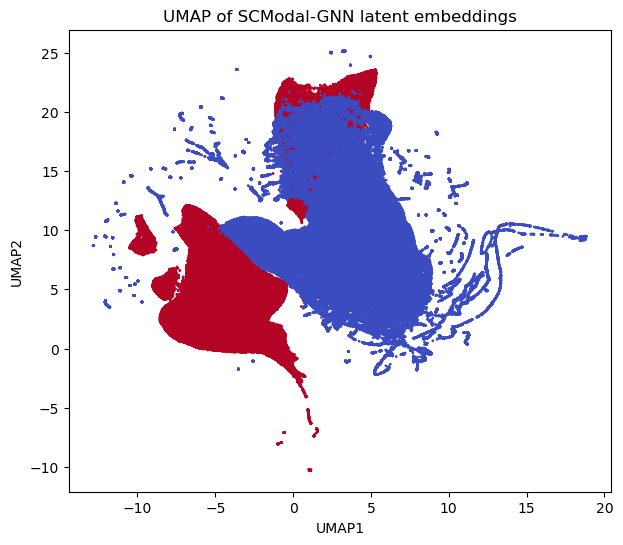

In [71]:
import numpy as np
import umap
import matplotlib.pyplot as plt

# m.latent is an (NA + NB) × latent_dim array
Z = m.latent
#save Z
# Build UMAP
um = umap.UMAP(n_neighbors=20, min_dist=0.1, metric="euclidean", random_state=42)
Z_umap = um.fit_transform(Z)

# Colors: dataset label
labels = np.array(
    ["A"] * m.emb_A.shape[0] + 
    ["B"] * m.emb_B.shape[0]
)

plt.figure(figsize=(7,6))
plt.scatter(Z_umap[:,0], Z_umap[:,1], c=(labels=="A"), cmap="coolwarm", s=6)
plt.title("UMAP of SCModal-GNN latent embeddings")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()


In [41]:
import numpy as np

unique_labels = np.unique(cell_labels)
for lab in unique_labels:
    idx = np.where(cell_labels == lab)[0]
    Z_lab = Z[idx]
    # Pairwise distance to centroid
    centroid = Z_lab.mean(axis=0)
    mean_dist = np.mean(np.linalg.norm(Z_lab - centroid, axis=1))
    print(f"{lab}: mean distance = {mean_dist:.4f}")


B-cells: mean distance = 1.9856
CAFs: mean distance = 1.7049
Cancer Epithelial: mean distance = 2.0749
Endothelial: mean distance = 2.0846
Myeloid: mean distance = 2.0385
Normal Epithelial: mean distance = 1.8843
PVL: mean distance = 2.2873
Plasmablasts: mean distance = 2.1298
T-cells: mean distance = 2.2270
Unlabeled: mean distance = 1.6741


In [12]:
import os
## Store the embeddings
save_dir = "SCModal_embeddings"
os.makedirs(save_dir, exist_ok=True)

np.save(os.path.join(save_dir, "latent.npy"), m.latent)
np.save(os.path.join(save_dir, "data_Aspace.npy"), m.data_Aspace)
np.save(os.path.join(save_dir, "data_Bspace.npy"), m.data_Bspace)

print("Saved: latent.npy, data_Aspace.npy, data_Bspace.npy")

Saved: latent.npy, data_Aspace.npy, data_Bspace.npy


In [42]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd


emb_A = Z[:X_spat.shape[0], :]
emb_B = Z[X_spat.shape[0]:, :]

nbrs = NearestNeighbors(n_neighbors=10, metric='cosine').fit(emb_B)
knn_idx = nbrs.kneighbors(emb_A, return_distance=False)

# Factorize string labels to numeric
labels = y_ref
codes, uniques = pd.factorize(labels)
neighbor_codes = codes[knn_idx]

# Majority vote using bincount (fast + numeric)
majority_idx = np.apply_along_axis(lambda x: np.bincount(x).argmax(), 1, neighbor_codes)
majority_labels = uniques[majority_idx]

preds = majority_labels



In [43]:
from sklearn.metrics import adjusted_rand_score, classification_report
ari = adjusted_rand_score(y_spat, preds)
print("Imputed cell type ARI:", ari)

Imputed cell type ARI: 0.03747522646954488


In [47]:
print(classification_report(y_spat, preds))

/home/keerthana/anaconda3/envs/scmodal_scviva/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/keerthana/anaconda3/envs/scmodal_scviva/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/keerthana/anaconda3/envs/scmodal_scviva/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

                   precision    recall  f1-score   support

          B-cells       0.38      0.06      0.10      4987
             CAFs       0.49      0.06      0.10     41422
Cancer Epithelial       0.28      0.13      0.18     62755
      Endothelial       0.00      0.00      0.00      9778
          Myeloid       0.00      0.01      0.00     13757
Normal Epithelial       0.01      0.00      0.00      9938
              PVL       0.00      0.00      0.00         0
     Plasmablasts       0.00      0.00      0.00         0
          T-cells       0.13      0.69      0.23     16589
        Unlabeled       0.00      0.00      0.00      8554

         accuracy                           0.13    167780
        macro avg       0.13      0.09      0.06    167780
     weighted avg       0.25      0.13      0.12    167780



/home/keerthana/anaconda3/envs/scmodal_scviva/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/keerthana/anaconda3/envs/scmodal_scviva/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
